<a href="https://colab.research.google.com/github/mbao01/AML-DS-2021/blob/main/notebooks/AML_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Week 2: Neural Network Architectures: CNN and Training Nets 
```
- Advanced Machine Learning, Innopolis University 
- Professor: Muhammad Fahim 
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>

```
Lab Plan

0. Previous Lab discussion & comments
1. Loading of dataset
2. Simple CNN model
3. Training Simple CNN Model (Classification Task)
4. Transfer Learning for CNN
5. Model Comparision
6. Lab Task
```



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## Load data and preprocess

## Load data and preprocess

To load our data set (CIFAR10) we can either download it manualy or use torchvision package. `torchvision` consists of popular datasets, model architectures, and common image transformations for computer vision.


For smooth training of the CNN we need to transform (normalize) the images. `transforms` package conatains common image transformations. Image transformations can be chained together using `transforms.Compose`. In our case we need to first convert image to tensor `transforms.ToTensor()` then normalize `transforms.Normalize`

The packages can be pip installed<br>
`!pip install torch` <br>
`!pip install torchvision`


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Data visualization 
Create a simple method to have a look at the data (image)

  cat  frog


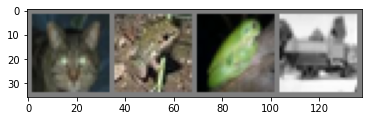

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(2)))

## Lets Switch to the GPU (if available) - why?


Unlike TensorFlow, PyTorch doesn’t have a dedicated library for GPU users,so its neccessary to some manual setup <br>
<b>NB: </b>If working on Colab, make sure that GPU runtime is enabled <br>
<b>NB: </b>It’s not possible to transfer Data Loaders directly to GPU <br>

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


## Create a Simple Convolutional neural network (CNN)

The simple CNN is made up of 2D Convolutional layers, Pooling layers and fully connected layers. <br> 
<b>NB : </b> If we succesfully connected to GPU, we need to send our CNN model to GPU for faster training

In [5]:
#TODO: Create the Net by defining the missing (None) convolutional layers, Max pool and fully connected layers 
#TODO: Finish implementation of foward method in class Net
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self, output_dim=10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, stride = 1, padding = 1)
        self.pool = nn.MaxPool2d(2, 2) # Max Pooling (2, 2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=16, kernel_size=8, stride = 1, padding = 1) # Convolution
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, output_dim) # output layer with 10 neurones

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        # x = x.view(-1, 400) # flatten the output of previous layer using x.view(...) x.view(400, -1) x.view(16 * 5 * 5, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net = net.to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 32, 32]             140
         MaxPool2d-2            [-1, 5, 16, 16]               0
            Conv2d-3           [-1, 16, 11, 11]           5,136
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 60]           7,260
            Linear-7                   [-1, 10]             610
Total params: 61,266
Trainable params: 61,266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.23
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


## CNN training 

What are the steps for training a neural network? 
<br> How do we send the data to training device (i.e GPU) durring the training process? Remember we train using batches. 

In [6]:
import torch.optim as optim
def train_evaluate(net, writer=None):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(1):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0): #TODO: Iterate through the batches and train the cnn
            # TODO : get the inputs and place them to the training devide (i.e GPU or CPU) 
            inputs, labels = data
            to_inputs = inputs.to(device)
            to_labels = labels.to(device)

            optimizer.zero_grad()

            # TODO : Train procedure -> zero the parameter gradients, forward pass + backward pass + optimize
            outputs = net(to_inputs) #Foward pass
            
            loss = criterion(outputs.to(device),to_labels) # Calcutation of loss
            loss.backward() 

            optimizer.step()

            # print statistics (print every 2000 mini-batches)
            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                if writer:
                    writer.add_scalar("Loss/train", running_loss, i)
                    for tag, parm in net.named_parameters():
                        writer.add_histogram(tag, parm.grad.data.cpu().numpy(), i)
                running_loss = 0.0
            # if writer:
            #     grid = torchvision.utils.make_grid(to_inputs)
            #     writer.add_image('images', grid, 0)
            #     writer.add_graph(net, to_inputs)

    print('Finished Training')
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    
    # print sample images and their predicted labels
    imshow(torchvision.utils.make_grid(images))
    plt.show()
    
    images, labels = images.to(device), labels.to(device)
    outputs = net(images).cuda()
    _, predicted = torch.max(outputs, 1)
    
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
    
    #Print Model overall Accuracy 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    
    #Print Model classwise Accuracy 
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

## Simple CNN training and Evaluation

[1,  2000] loss: 2.154
[1,  4000] loss: 1.870
[1,  6000] loss: 1.700
[1,  8000] loss: 1.621
[1, 10000] loss: 1.543
[1, 12000] loss: 1.480
Finished Training


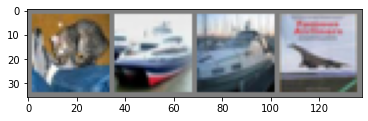

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car  ship  ship
Accuracy of the network on the 10000 test images: 45 %
Accuracy of plane : 60 %
Accuracy of   car : 87 %
Accuracy of  bird : 26 %
Accuracy of   cat : 25 %
Accuracy of  deer : 15 %
Accuracy of   dog : 34 %
Accuracy of  frog : 65 %
Accuracy of horse : 64 %
Accuracy of  ship : 54 %
Accuracy of truck : 20 %


In [7]:
train_evaluate(net)

## CNN from popular model architectures (Transfer learning)

Same procedure as simple CNN but the achitecture of the neural net is much more complicated and the weights are pretrained. <br> 

### Fine Tuning
Fine tuning or transfer learning is the task of training a model on a big dataset and then adjucting the parameters of the model for a smaller task with less data.

It is very common in Computer Vision and Natural Language Processing with the immergence of BERT and UMLfit. 
![](https://miro.medium.com/max/1276/1*ZkPBqU8vx2vAgcLpz9pi5g.jpeg)

Say we want to use resnet (trained on imagenet with 1000 classes and has input shape of 256x256)  and fine-tune it for CIFAR10 (has 10 categories with input shape of 32×32)

What is the biggest changes that we need to make?



## How to Import Popular CNN models? 

`torchvision,models` contains of popular model architectures and can be loaded together with their trained weights

In [8]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True,progress=True)
alexnet = models.alexnet(pretrained=True,progress=True)
squeezenet = models.squeezenet1_0(pretrained=True,progress=True)
vgg16 = models.vgg16(pretrained=True,progress=True)
densenet = models.densenet161(pretrained=True,progress=True)
inception = models.inception_v3(pretrained=True,progress=True)
googlenet = models.googlenet(pretrained=True,progress=True)
shufflenet = models.shufflenet_v2_x1_0(pretrained=True,progress=True)
mobilenet = models.mobilenet_v2(pretrained=True,progress=True)
resnext50_32x4d = models.resnext50_32x4d(pretrained=True,progress=True)
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True,progress=True)
mnasnet = models.mnasnet1_0(pretrained=True,progress=True)

## Start by loading and transforming the data 

In [9]:
import torchvision.models as models

transform = transforms.Compose(
    [transforms.Resize((256,256)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Define CNN model 

<b>NB : </b>To make the model achitecture fit our classification task, we will change the last fully connected layer and train only it.

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = models.resnet18(pretrained=True,progress=True)
        self.net.trainable = False
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)


net = Net()
net = net.to(device)

## Train and Evaluate the CNN 

[1,  2000] loss: 1.212
[1,  4000] loss: 0.859
[1,  6000] loss: 0.709
[1,  8000] loss: 0.629
[1, 10000] loss: 0.602
[1, 12000] loss: 0.546
Finished Training


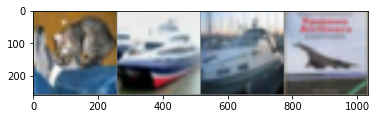

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship truck  bird
Accuracy of the network on the 10000 test images: 79 %
Accuracy of plane : 47 %
Accuracy of   car : 86 %
Accuracy of  bird : 89 %
Accuracy of   cat : 62 %
Accuracy of  deer : 71 %
Accuracy of   dog : 67 %
Accuracy of  frog : 91 %
Accuracy of horse : 87 %
Accuracy of  ship : 92 %
Accuracy of truck : 94 %


In [11]:
train_evaluate(net)

## <center>Lab Task</center>

```
1. Add Tensorboard to monitor the loss every after training with 2000 mini-batches
2. Create another CNN using pretrained model and compare it with already implemented resnet and simple CNN (plot their losses on same tensorboard)
3. Add the notebook to your Git repo with printed cells output
```

### 1. Add Tensorboard to monitor the loss every after training with 2000 mini-batches


In [12]:
%load_ext tensorboard

In [13]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [20]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6007 (pid 1685), started 1:08:56 ago. (Use '!kill 1685' to kill it.)

<IPython.core.display.Javascript object>

[1,  2000] loss: 0.437
[1,  4000] loss: 0.431
[1,  6000] loss: 0.439
[1,  8000] loss: 0.390
[1, 10000] loss: 0.385
[1, 12000] loss: 0.385
Finished Training


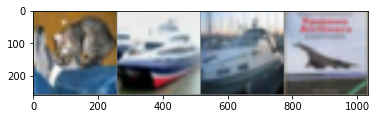

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 87 %
Accuracy of plane : 92 %
Accuracy of   car : 95 %
Accuracy of  bird : 88 %
Accuracy of   cat : 61 %
Accuracy of  deer : 89 %
Accuracy of   dog : 89 %
Accuracy of  frog : 85 %
Accuracy of horse : 92 %
Accuracy of  ship : 90 %
Accuracy of truck : 90 %


In [15]:
train_evaluate(net, writer)

### 2. Create another CNN using pretrained model and compare it with already implemented resnet and simple CNN (plot their losses on same tensorboard)


In [16]:
pt_model = torchvision.models.resnet18(pretrained=True)
num_ftrs = pt_model.fc.in_features

pt_model.fc = nn.Linear(num_ftrs, 10)

pt_model = pt_model.to(device)

summary(pt_model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

[1,  2000] loss: 1.223
[1,  4000] loss: 0.823
[1,  6000] loss: 0.710
[1,  8000] loss: 0.657
[1, 10000] loss: 0.590
[1, 12000] loss: 0.548
Finished Training


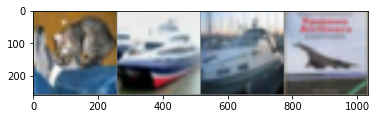

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 82 %
Accuracy of plane : 89 %
Accuracy of   car : 95 %
Accuracy of  bird : 73 %
Accuracy of   cat : 51 %
Accuracy of  deer : 88 %
Accuracy of   dog : 87 %
Accuracy of  frog : 89 %
Accuracy of horse : 88 %
Accuracy of  ship : 79 %
Accuracy of truck : 85 %


In [17]:
train_evaluate(pt_model, writer)

In [18]:
writer.close()